In [2]:
import nltk

print("NLTK version:", nltk.__version__)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

NLTK version: 3.9.2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parmisvazifeh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\parmisvazifeh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parmisvazifeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from pypdf import PdfReader
import re
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
pdf_path = "01-the-fellowship-of-the-ring-retail.pdf"

reader = PdfReader(pdf_path)
all_text = []
for page in reader.pages:
    t = page.extract_text() or ""
    all_text.append(t)

text = "\n".join(all_text)

start_match = re.search(
    r"\bBOOK\s+ONE\b[\s\S]{0,500}\bCHAPTER\s+1\b",
    text,
    flags=re.IGNORECASE
)
if not start_match:
    raise ValueError("Start of BOOK ONE (Chapter 1) not found")

start = start_match.start()

end_match = re.search(
    r"\bBOOK\s+TWO\b",
    text[start:],
    flags=re.IGNORECASE
)
if not end_match:
    raise ValueError("BOOK TWO not found")

end = start + end_match.start()

book1_text = text[start:end]

print("Book One chars:", len(book1_text))
print(book1_text[:800])


Book One chars: 486612
BOOK ONE
.
Chapter 1
A LONG-EXPECTED PARTY
When Mr. Bilbo Baggins of Bag End announced that he
would shortly be celebrating his eleventy-ﬁrst birthday with
a party of special magniﬁcence, there was much talk and
excitement in Hobbiton.
Bilbo was very rich and very peculiar, and had been the
wonder of the Shire for sixty years, ever since his remarkable
disappearance and unexpected return. The riches he had
brought back from his travels had now become a local legend,
and it was popularly believed, whatever the old folk might
say, that the Hill at Bag End was full of tunnels stuffed with
treasure. And if that was not enough for fame, there was also
his prolonged vigour to marvel at. Time wore on, but it
seemed to have little effect on Mr. Baggins. At ninety he was
much the same as at ﬁfty. A


In [5]:
STOP = set(stopwords.words("english"))

def normalize_for_tokens(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def make_sentences(raw_text: str):
    sents = sent_tokenize(raw_text)

    out = []
    for s in sents:
        s = normalize_for_tokens(s)
        toks = [w for w in word_tokenize(s) if w not in STOP and len(w) >= 2]
        if len(toks) >= 4:
            out.append(toks)
    return out

In [6]:
sentences = make_sentences(book1_text)
print("num sentences:", len(sentences))
print("sample:", sentences[0][:30])


num sentences: 4288
sample: ['chapter', 'long', 'expected', 'party', 'mr', 'bilbo', 'baggins', 'bag', 'end', 'announced', 'would', 'shortly', 'celebrating', 'eleventy', 'rst', 'birthday', 'party', 'special', 'magni', 'cence', 'much', 'talk', 'excitement', 'hobbiton']


In [7]:
w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=6,
    min_count=3,
    sg=1,          # skip-gram
    negative=10,
    epochs=25,
    workers=4
)

print("vocab size:", len(w2v.wv))

vocab size: 2322


In [8]:
"sauron" in w2v.wv

True

In [9]:
def nn(word, topn=10):
    if word not in w2v.wv:
        return f"'{word}' not in vocab"
    return w2v.wv.most_similar(word, topn=topn)

def analogy(positive, negative, topn=10):
    missing = [w for w in positive + negative if w not in w2v.wv]
    if missing:
        return f"Missing in vocab: {missing}"
    return w2v.wv.most_similar(positive=positive, negative=negative, topn=topn)

In [10]:
print("ring:", nn("ring"))
print("gandalf:", nn("gandalf"))
print("frodo:", nn("frodo"))
print("shire:", nn("shire"))


ring: [('fellowship', 0.6729537844657898), ('weighed', 0.6582061052322388), ('maker', 0.657527506351471), ('fears', 0.6122879385948181), ('month', 0.610617995262146), ('loss', 0.6057079434394836), ('ful', 0.6034904718399048), ('addressed', 0.603441596031189), ('beat', 0.6026659607887268), ('nger', 0.5972321033477783)]
gandalf: [('letter', 0.6664684414863586), ('absence', 0.6595382690429688), ('tight', 0.649155855178833), ('wizard', 0.6433818936347961), ('wish', 0.6397345066070557), ('secretly', 0.6357634663581848), ('read', 0.6350787878036499), ('yes', 0.6337493658065796), ('counsel', 0.6324058771133423), ('waited', 0.6291950941085815)]
frodo: [('bowing', 0.672204315662384), ('waited', 0.6621484160423279), ('wildly', 0.6571251153945923), ('absence', 0.651862621307373), ('tight', 0.6457533836364746), ('liking', 0.645399272441864), ('beast', 0.645226001739502), ('older', 0.643061101436615), ('letter', 0.6398335695266724), ('raising', 0.6392372250556946)]
shire: [('outsiders', 0.617791533

In [11]:
print(analogy(["frodo", "wizard"], ["hobbit"], topn=10))
print(analogy(["gandalf", "dark"], ["wizard"], topn=10))
print(analogy(["shire", "inn"], ["hobbiton"], topn=10))
print(analogy(["strider", "hobbit"], ["frodo"], topn=10))


[('gandalf', 0.6530924439430237), ('precious', 0.6085705161094666), ('letter', 0.6070599555969238), ('yes', 0.6066901087760925), ('killed', 0.583672285079956), ('eh', 0.5783336162567139), ('plan', 0.5740681886672974), ('tight', 0.5698578357696533), ('astonishment', 0.562378466129303), ('effort', 0.5618234276771545)]
[('lord', 0.5860927104949951), ('lie', 0.5060892701148987), ('spirit', 0.49537786841392517), ('die', 0.4933013319969177), ('shapes', 0.486298143863678), ('du', 0.483749657869339), ('northern', 0.47349783778190613), ('amid', 0.46707776188850403), ('sea', 0.4654676616191864), ('angmar', 0.4649987816810608)]
[('different', 0.4957622289657593), ('visit', 0.493539035320282), ('brief', 0.4917416572570801), ('rangers', 0.4903334975242615), ('friendship', 0.4899469017982483), ('trusted', 0.48935195803642273), ('local', 0.4790680706501007), ('driven', 0.4784339666366577), ('accounts', 0.472213476896286), ('skill', 0.4574936330318451)]
[('villages', 0.43465185165405273), ('rangers', 

In [12]:
words = w2v.wv.index_to_key[:2500]
X = np.vstack([w2v.wv[w] for w in words])
print(X.shape)

(2322, 200)


In [13]:
k = 12
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = km.fit_predict(X)

clusters = defaultdict(list)
for w, lab in zip(words, labels):
    clusters[lab].append(w)

for lab in range(k):
    print(f"\nCluster {lab}:")
    print(clusters[lab][:25])


Cluster 0:
['road', 'way', 'end', 'left', 'day', 'soon', 'nd', 'house', 'make', 'north', 'open', 'country', 'cut', 'danger', 'journey', 'ford', 'except', 'miles', 'rivendell', 'bridge', 'follow', 'nearly', 'next', 'best', 'straight']

Cluster 1:
['old', 'bilbo', 'good', 'took', 'hobbit', 'indeed', 'bag', 'also', 'people', 'rather', 'party', 'home', 'gave', 'young', 'new', 'guests', 'brought', 'every', 'expected', 'food', 'kept', 'queer', 'hobbiton', 'four', 'supper']

Cluster 2:
['went', 'round', 'side', 'along', 'turned', 'right', 'path', 'towards', 'fell', 'tree', 'deep', 'gate', 'wide', 'ground', 'ran', 'short', 'ponies', 'low', 'across', 'edge', 'walked', 'hedge', 'quickly', 'thick', 'bank']

Cluster 3:
['tom', 'fellowship', 'began', 'little', 'eyes', 'hand', 'feet', 'drew', 'small', 'face', 'slowly', 'head', 'inside', 'became', 'bombadil', 'caught', 'full', 'bed', 'table', 'goldberry', 'heavy', 'hands', 'window', 'silence', 'strong']

Cluster 4:
['mr', 'baggins', 'name', 'butterb

Cluster 0: General Actions and Intentions

Cluster 1: Dialogue and Cognition

Cluster 2: Local Natural Landscape

Cluster 3: Movement and Small Locations

Cluster 4: Geography and Long-Distance Travel

Cluster 5: Poetic Imagery and Atmosphere

Cluster 6: Narrative Concept: The Shadow of the Past

Cluster 7: Main Characters and Emotional Core

Cluster 8: Tom Bombadil Subworld

Cluster 9: Mythology and World-Building

Cluster 10: Hobbit Life in the Shire

Cluster 11: Darkness, Threat, and Pursuit

This is worth noting that the one cluster was dedicated to the Tom Bombadil a unique character who appears only in The Fellowship of the Ring. He lives in the Old Forest with his wife, Goldberry, and is strongly associated with songs, nature, and ancient landscapes. Unlike all other characters, the One Ring has no power over him. Tom exists outside the central conflict of power in Middle-earth, representing a self-contained “subworld” that is independent of the struggle between good and evil. He himself stated that he is older than Saoron

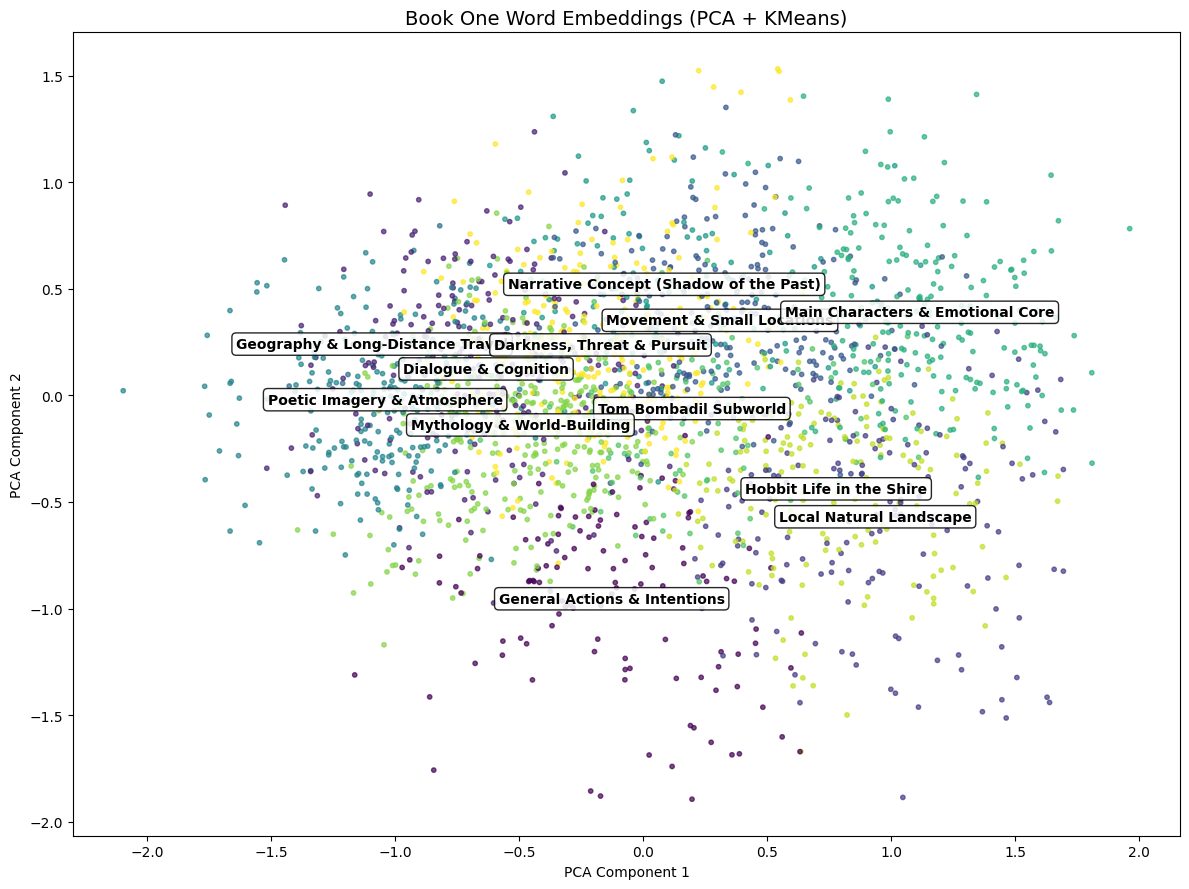

In [14]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)
centroids_2d = pca.transform(km.cluster_centers_)

cluster_names = {
    0: "General Actions & Intentions",
    1: "Dialogue & Cognition",
    2: "Local Natural Landscape",
    3: "Movement & Small Locations",
    4: "Geography & Long-Distance Travel",
    5: "Poetic Imagery & Atmosphere",
    6: "Narrative Concept (Shadow of the Past)",
    7: "Main Characters & Emotional Core",
    8: "Tom Bombadil Subworld",
    9: "Mythology & World-Building",
    10: "Hobbit Life in the Shire",
    11: "Darkness, Threat & Pursuit",
}

plt.figure(figsize=(12, 9))
plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=10, alpha=0.7)

for i, (cx, cy) in enumerate(centroids_2d):
    plt.text(
        cx, cy,
        cluster_names.get(i, f"Cluster {i}"),
        fontsize=10, weight="bold",
        ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.85)
    )

plt.title("Book One Word Embeddings (PCA + KMeans)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [15]:
def plot_clusters_with_word_labels(
    X, X2, labels, km, words, target_words, cluster_names
):
    plt.figure(figsize=(12, 9))
    
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=10, alpha=0.6)

    pca = PCA(n_components=2, random_state=42)
    pca.fit(X)
    centroids_2d = pca.transform(km.cluster_centers_)

    for i, (cx, cy) in enumerate(centroids_2d):
        plt.text(
            cx, cy,
            cluster_names.get(i, f"Cluster {i}"),
            fontsize=10,
            weight="bold",
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.85)
        )

    for w in target_words:
        if w in words:
            idx = words.index(w)
            plt.text(
                X2[idx, 0],
                X2[idx, 1],
                w,
                fontsize=9,
                color="black",
                ha="center",
                va="center"
            )

    plt.title("Book One Word Embeddings (PCA + KMeans)", fontsize=14)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

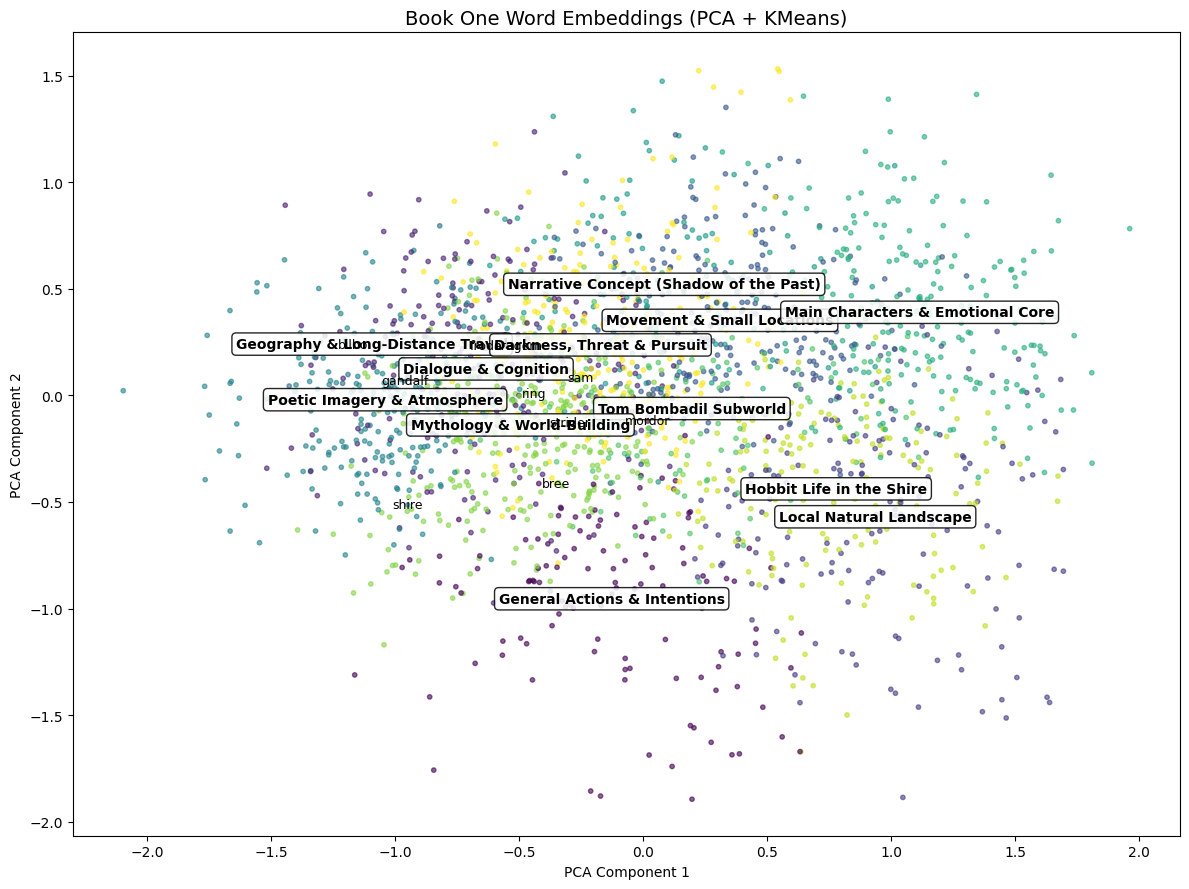

In [16]:
cluster_names = {
    0: "General Actions & Intentions",
    1: "Dialogue & Cognition",
    2: "Local Natural Landscape",
    3: "Movement & Small Locations",
    4: "Geography & Long-Distance Travel",
    5: "Poetic Imagery & Atmosphere",
    6: "Narrative Concept (Shadow of the Past)",
    7: "Main Characters & Emotional Core",
    8: "Tom Bombadil Subworld",
    9: "Mythology & World-Building",
    10: "Hobbit Life in the Shire",
    11: "Darkness, Threat & Pursuit",
}

plot_clusters_with_word_labels(
    X=X,
    X2=X2,
    labels=labels,
    km=km,
    words=words,
    target_words=[
        "frodo","sam","gandalf","bilbo","ring",
        "shire","bree","strider","aragorn","mordor"
    ],
    cluster_names=cluster_names
)